In [0]:
# Education - Udacity "Intro to TensorFlow for Deep Learning"
# Module: Moving Average Forecast
# REF: https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c03_moving_average.ipynb

In [2]:
# Import packages.
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import matplotlib.pyplot as plt

# Using version 2.x of Tensorflow.
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Tensorflow.
import tensorflow as tf

# Print Tensorflow version.
print('TensorFlow Version:', tf.__version__)

TensorFlow 2.x selected.
TensorFlow Version: 2.1.0


In [0]:
# ====================
# Helper Function
# ====================
# Plot serie.
def plot_series(time, series, format="-", start=0, end=None, label=None):
  plt.plot(time[start:end], series[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Value")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)


# Trend.
def trend(time, slope=0):
  return slope * time


# Seasonal pattern.
def seasonal_pattern(season_time):
  # Just an arbitrary pattern.
  return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1 / np.exp(3 * season_time))


# Seasonality.
def seasonality(time, period, amplitude=1, phase=0):
  # Repeats the same pattern at each period.
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)


# White noise.
def white_noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

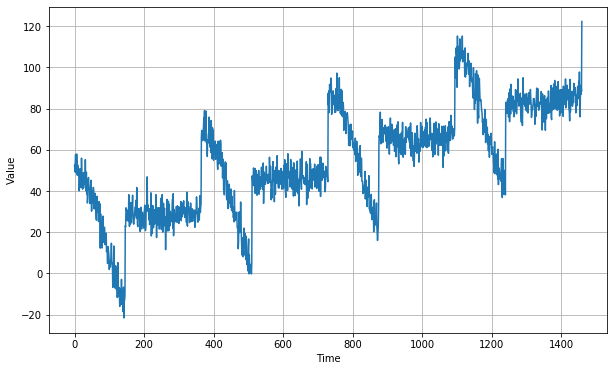

In [4]:
# Create a time series.
time      = np.arange(4 * 365 + 1)
slope     = 0.05
baseline  = 10
amplitude = 40
series    = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise       = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

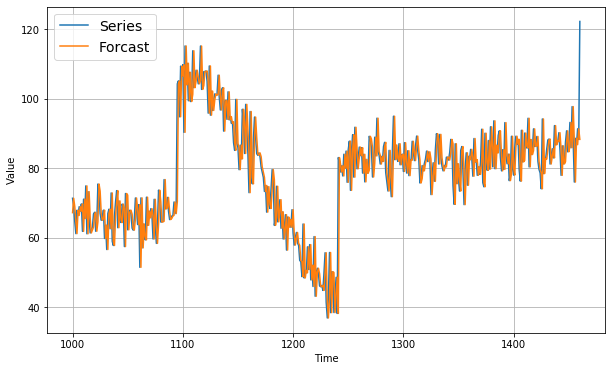

In [5]:
# ====================
# Naive Forcast
# ====================
split_time        = 1000
time_train        = time[:split_time]
time_validation   = time[split_time:]
series_train      = series[:split_time]
series_validation = series[split_time:]

naive_forcast = series[split_time - 1 : -1]

plt.figure(figsize=(10, 6))
plot_series(time_validation, series_validation, label = "Series")
plot_series(time_validation, naive_forcast, label = "Forcast")

In [6]:
# Compute MSE (Mean Squared Error).
 mse = tf.keras.metrics.mean_absolute_error(series_validation, naive_forcast).numpy()
 print("MSE:", mse)

MSE: 5.9379085153216735


In [0]:
# Moving average forecast.
# This "predict" the value as the mean average of the past values.
# For instance the past 30 days.
def moving_average_forecast_legacy(series, window_size):
  # Forecasts the mean of the last few values.
  # If window size = 1, then this is equivalent to naive forecast.
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)


# This implementation is more "faster" than the one above.
def moving_average_forecast(series, window_size):
  mov = np.cumsum(series)
  mov[window_size:] = mov[window_size:] - mov[:-window_size]
  return mov[window_size - 1:-1] / window_size

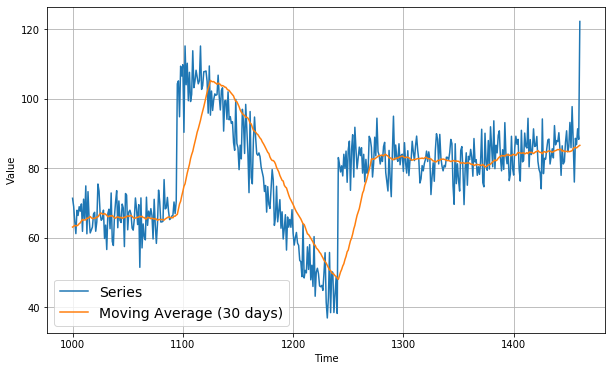

In [8]:
# Create a forcast for the past 30 days.
ma_forecast = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_validation, series_validation, label = "Series")
plot_series(time_validation, ma_forecast, label = "Moving Average (30 days)")

In [9]:
# Compute MSE (Mean Squared Error).
 mse = tf.keras.metrics.mean_absolute_error(series_validation, ma_forecast).numpy()
 print("MSE:", mse)

MSE: 7.1424185706207854


In [0]:
# As we see from the result, the forecast is quite good when values are stabile.
# When the series contains big changes, the forecast would give a bad forecast.

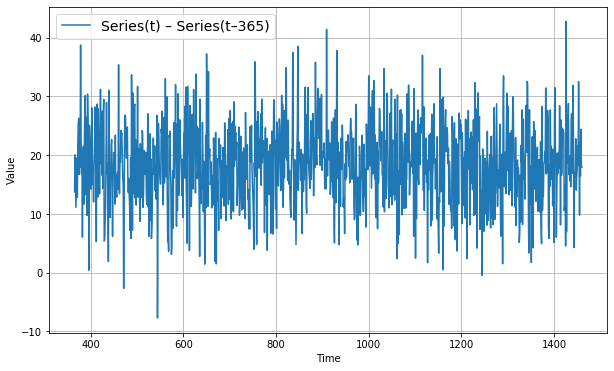

In [11]:
# Differencing is to remove the noise and seasonality.
# Since the seasonality period is 365 days,
# we will subtract the value at time t – 365 from the value at time t.
diff_series = (series[365:] - series[:-365])
diff_time   = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series, label="Series(t) – Series(t–365)")
plt.show()

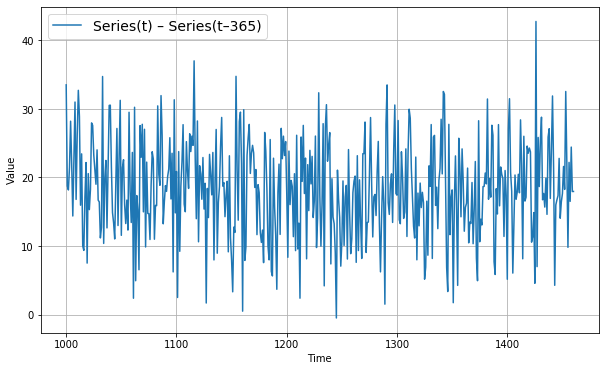

In [12]:
# Zooming in.
plt.figure(figsize=(10, 6))
plot_series(time_validation, diff_series[split_time - 365:], label="Series(t) – Series(t–365)")
plt.show()

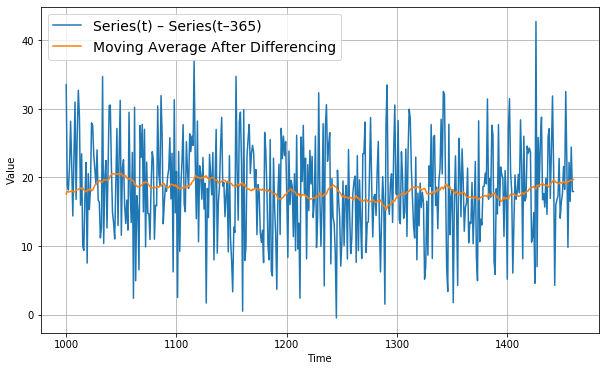

In [13]:
# We see that the trend and seasonality are removed, which is good.
# Forcast on the diff_series.
dma_forecast = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_validation, diff_series[split_time - 365:], label="Series(t) – Series(t–365)")
plot_series(time_validation, dma_forecast, label="Moving Average After Differencing")
plt.show()

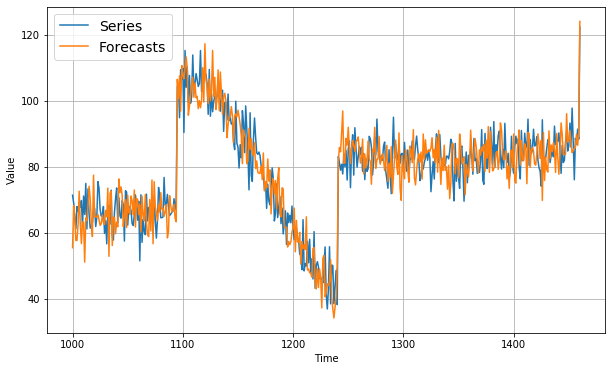

In [14]:
# Let's brind back the trend and seasonality by adding the past values from t - 365.
dma_forecast_past = series[split_time - 365:-365] + dma_forecast

plt.figure(figsize=(10, 6))
plot_series(time_validation, series_validation, label="Series")
plot_series(time_validation, dma_forecast_past, label="Forecasts")
plt.show()

In [15]:
# Compute MSE (Mean Squared Error).
 mse = tf.keras.metrics.mean_absolute_error(series_validation, dma_forecast_past).numpy()
 print("MSE:", mse)

MSE: 5.8393105629958955


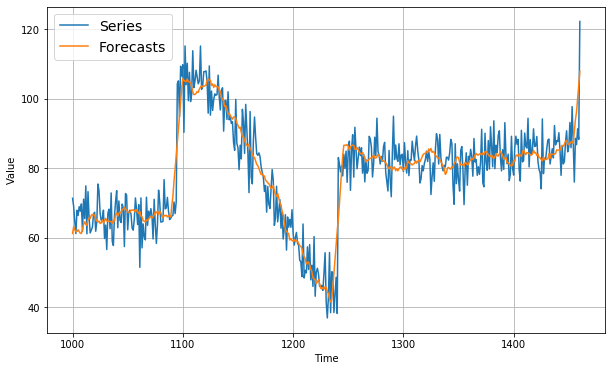

In [16]:
# Let's forecast on the past values to remove some of the noise.
dma_smooth = moving_average_forecast(series[split_time - 370: - 359], 11) + dma_forecast

plt.figure(figsize=(10, 6))
plot_series(time_validation, series_validation, label="Series")
plot_series(time_validation, dma_smooth, label="Forecasts")
plt.show()

In [17]:
# Compute MSE (Mean Squared Error).
 mse = tf.keras.metrics.mean_absolute_error(series_validation, dma_smooth).numpy()
 print("MSE:", mse)

MSE: 4.566859958970772
